## **Sugarcane Leaf Disease Dataset**
About the dataset:
The dataset comprises of manually collected images of Sugarcane leaf disease. It can be classified into 5 main categories:


*   Healthy
*   Mosaic
*   Redrot
*   Rust
*   Yellow

Link to the dataset - https://www.kaggle.com/datasets/nirmalsankalana/sugarcane-leaf-disease-dataset



In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import cv2

import os

In [2]:
#Loading the dataset from Google Drive

dataset_path = '/content/drive/MyDrive/Sugarcane_leaf_disease_detection'

target_size = (125, 125)
dataset = []
labels = []

for label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, label)

        if os.path.isdir(class_path):
          images_counter = 0

        #Iterating over all the images in a folder
        for img_name in os.listdir(class_path):
          img_path = os.path.join(class_path, img_name)

          image = cv2.imread(img_path)
          # Check if the image was loaded successfully
          if image is not None:
              # Resize the image
              image = cv2.resize(image, target_size)

              # Add image and label to dataset
              dataset.append(image)
              labels.append(label)


          else:
              print(f"Error loading image: {img_path}")

**Visualizing the dataset distribution of all labels**

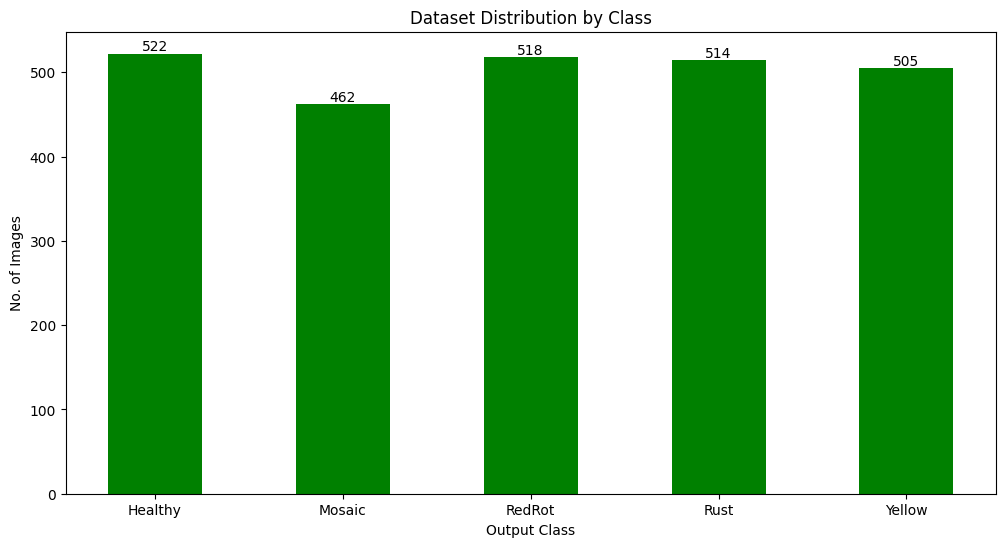

In [3]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_counts.keys(), class_counts.values(), color='green', width = 0.5)
ax.set_xlabel('Output Class')
ax.set_ylabel('No. of Images')

ax.set_title('Dataset Distribution by Class')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()

**Images of the leaves**

In [4]:
import random

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))

    labels_array = np.array(labels)
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels_array == class_name)[0]

        if len(indices_class) > 0:
            sample_index = random.choice(indices_class)
        else:
            continue

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



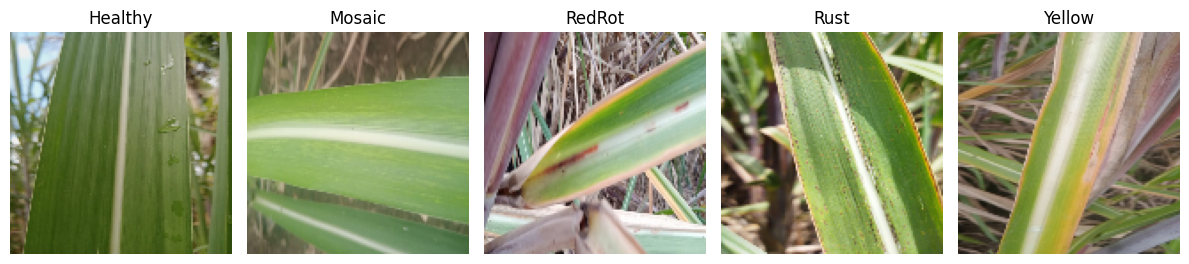

In [5]:
unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

**Train - Test split of the dataset & carrying out label encoding**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size = 0.2, )

def preprocess_image(image):
    resized_image = cv2.resize(image, (125, 125))

    #Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (2016, 125, 125, 3)
Shape of X_test: (505, 125, 125, 3)
Shape of y_train: (2016,)
Shape of y_test: (505,)


**Network Architecture - EfficientNet**

In [7]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [8]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop

In [9]:
num_classes = len(np.unique(labels))

model = models.Sequential()

efficientnet_model = EfficientNetB0(input_shape=(125, 125, 3), include_top=False, weights='imagenet', pooling='max')

model.add(efficientnet_model)

model.add(Dense(128, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
custom_optimizer = RMSprop(learning_rate=0.0001)

model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])

16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/150
63/63 [==============================] - 173s 2s/step - loss: 3.0205 - accuracy: 0.2207 - val_loss: 2.2948 - val_accuracy: 0.2515
Epoch 2/150
63/63 [==============================] - 146s 2s/step - loss: 2.2912 - accuracy: 0.3482 - val_loss: 2.2243 - val_accuracy: 0.3208
Epoch 3/150
63/63 [==============================] - 155s 2s/step - loss: 2.0441 - accuracy: 0.4534 - val_loss: 2.1084 - val_accuracy: 0.3564
Epoch 4/150
63/63 [==============================] - 145s 2s/step - loss: 1.8556 - accuracy: 0.5248 - val_loss: 1.8789 - val_accuracy: 0.5069
Epoch 5/150
63/63 [==============================] - 146s 2s/step - loss: 1.7282 - accuracy: 0.5774 - val_loss: 1.6959 - val_accuracy: 0.5703
Epoch 6/150
63/63 [==============================] - 147s 2s/step - loss: 1.5776 - accuracy: 0.6483 - val_loss: 1.5727 - val_accuracy: 0.6535
Epoch 7/150
63/63 [==============================] - 144s 2s/step - loss: 1.4605 - 

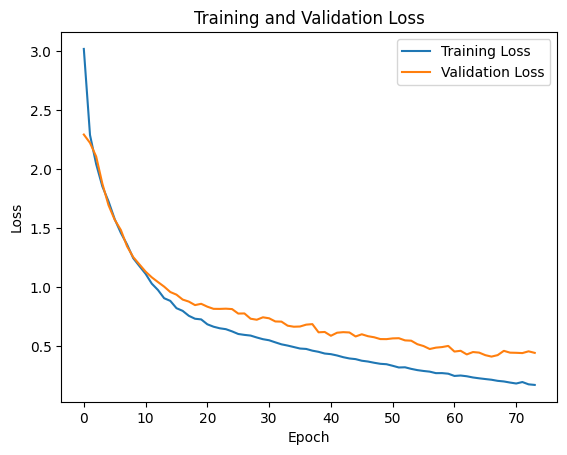

In [10]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

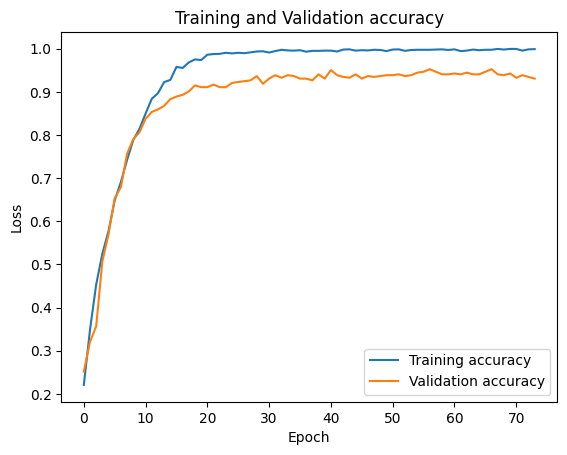

In [11]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 11s 517ms/step


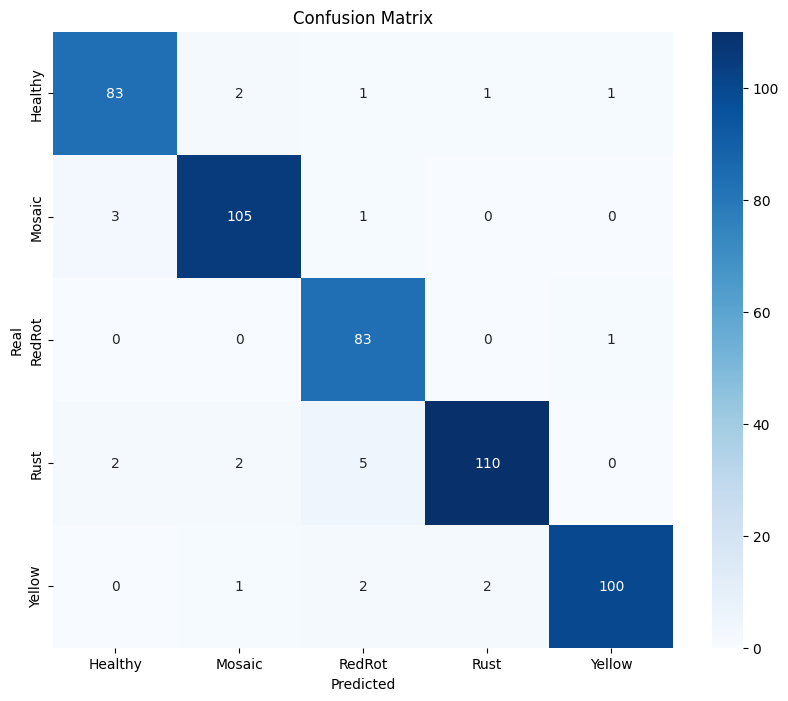

              precision    recall  f1-score   support

     Healthy       0.94      0.94      0.94        88
      Mosaic       0.95      0.96      0.96       109
      RedRot       0.90      0.99      0.94        84
        Rust       0.97      0.92      0.95       119
      Yellow       0.98      0.95      0.97       105

    accuracy                           0.95       505
   macro avg       0.95      0.95      0.95       505
weighted avg       0.95      0.95      0.95       505



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

In [17]:
model.save('efficientnet_model_sg.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
